In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import keras
from keras import backend
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Attention, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle
import mlflow
import time
import logging

import optuna
import optuna.visualization as vis
from optuna.pruners import MedianPruner

2025-02-27 00:20:57.642514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740612057.702782   24094 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740612057.720844   24094 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 00:20:57.863127: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model Fine-Tuning

## 1. Data Preprocessing

To properly load the Bitcoin data, you must first **prepare** and **save** the **prepocessed** data in the **[main notebook](1.Time-Series-Forecasting.ipynb)**.

In [2]:
btc_price_data_1_year = pd.read_csv("data/btc_price_data_1_year_prepocessed.csv")
btc_price_data_1_year.set_index('timestamp', inplace=True, drop = True)
btc_price_data_1_year

,open,high,low,close,volume,returns,log_returns,volume_ma,volume_std,sma_20,...,seasonal_lag_13,close_trend_diff_lag_13,close_seasonal_diff_lag_13,lag_16,trend_lag_16,seasonal_lag_16,close_trend_diff_lag_16,close_seasonal_diff_lag_16,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 00:49:00,40096.06,40117.78,40096.06,40109.60,10.527911,3.411818e-04,3.411237e-04,9.599183,6.414985,40080.4245,...,3.364993,-20.132128,40046.695007,40022.89,40061.968191,3.547758,-39.078191,40019.342242,2.592895e-04,1
2024-01-25 00:50:00,40099.42,40120.00,40109.59,40120.00,4.440333,2.592895e-04,2.592559e-04,8.592098,5.053382,40084.7810,...,-6.199338,-28.315773,40051.229338,40015.81,40064.501111,5.611222,-48.691111,40010.198778,-4.349452e-04,0
2024-01-25 00:51:00,40102.55,40121.45,40116.87,40102.55,3.447542,-4.349452e-04,-4.350398e-04,8.493151,5.132602,40089.3455,...,-7.452409,-19.021626,40065.122409,40034.50,40067.242085,7.111680,-32.742085,40027.388320,1.780435e-04,1
2024-01-25 00:52:00,40097.26,40113.46,40101.91,40109.69,3.290059,1.780435e-04,1.780277e-04,8.310886,5.239860,40094.0915,...,11.015553,32.162931,40101.354447,40050.06,40070.192128,3.364993,-20.132128,40046.695007,6.282771e-04,1
2024-01-25 00:53:00,40109.64,40139.98,40109.64,40134.89,8.306779,6.282771e-04,6.280798e-04,8.371737,5.230584,40099.6915,...,27.264336,59.184818,40115.775664,40045.03,40073.345773,-6.199338,-28.315773,40051.229338,1.041488e-04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-23 23:55:00,104056.76,104094.48,104081.55,104063.93,2.583412,-1.691943e-04,-1.692086e-04,5.142179,3.397725,104149.6940,...,14.288221,-1.677994,104229.931779,104193.14,104246.474556,-99.426524,-53.334556,104292.566524,1.508688e-04,1
2025-01-23 23:56:00,104047.01,104112.45,104064.68,104079.63,6.922352,1.508688e-04,1.508574e-04,5.271726,3.404118,104137.7735,...,-147.321386,-66.376407,104326.741386,104255.27,104246.247767,-17.534426,9.022233,104272.804426,-2.882408e-07,0
2025-01-23 23:57:00,104052.01,104088.97,104079.63,104079.60,1.628341,-2.882408e-07,-2.882409e-07,4.979213,3.402950,104129.8905,...,-193.631723,-67.661021,104371.711723,104191.77,104246.049439,-63.662497,-54.279439,104255.432497,-1.104731e-03,0


In [3]:
# For fast execution get only the first 50_000 rows for fine tuning
btc_price_data_1_year = btc_price_data_1_year[:50000]

### 1.1. One-hot encoding for categorical features

In [4]:
# btc_price_data_1_year = pd.get_dummies(btc_price_data_1_year, columns=['day_of_week', 'day_of_month', 'month'], drop_first=True) # drop_first to avoid multicollinearity

### 1.2. Split the Dataset

The data is split chronologically to avoid data leakage:
- **Training set**: 80% of the data (used for training the model).
- **Validation set**: 10% of the data (used for hyperparameter tuning).
- **Test set**: 10% of the data (used to evaluate final performance).

In [5]:
# Split the dataset into train, validation, and test sets
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Compute split indices
train_idx = int(len(btc_price_data_1_year) * train_size)
val_idx = int(len(btc_price_data_1_year) * (train_size + val_size))

# Split the data
btc_price_data_1_year_train = btc_price_data_1_year[:train_idx]
X_train = btc_price_data_1_year_train.drop('target', axis=1)
y_train = btc_price_data_1_year_train['target']

btc_price_data_1_year_val = btc_price_data_1_year[train_idx:val_idx]
X_val = btc_price_data_1_year_val.drop('target', axis=1)
y_val = btc_price_data_1_year_val['target']

btc_price_data_1_year_test = btc_price_data_1_year[val_idx:]
X_test = btc_price_data_1_year_test.drop('target', axis=1)
y_test = btc_price_data_1_year_test['target']

print(f"Training set: {len(X_train)} rows")
print(f"Validation set: {len(X_val)} rows")
print(f"Test set: {len(X_test)} rows")

Training set: 40000 rows
Validation set: 5000 rows
Test set: 5000 rows


In [6]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(target
 1    20226
 0    19774
 Name: count, dtype: int64,
 target
 1    2531
 0    2469
 Name: count, dtype: int64,
 target
 1    2582
 0    2418
 Name: count, dtype: int64)

In [7]:
def plot_splitted_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    # x_lim_start = dates[0][0]
    # x_lim_end = dates[1][len(dates[1]) - 1]
    # # x_lim_end = dates[len(dates[0]) + len(dates[1]) - 1]
    # # plt.xlim(x_lim_start, x_lim_end)
    # ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates[0], prices[0], label ='Train Data')
    plt.plot(dates[1], prices[1], label ='Validation Data')
    plt.plot(dates[2], prices[2], label ='Test Data')
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
# dates_train = X_train.index
# prices_close_train = X_train.close

# dates_val = X_val.index
# prices_close_val = X_val.close

# dates_test = X_test.index
# prices_close_test = X_test.close

# dates = [dates_train, dates_val, dates_test]
# prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

# title_btc = 'Data Split (Jan 2024 - Jan 2025)'

# labels = ['Date', 'Price [USD]']

# plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

### 1.3. Scale Features

A **StandardScaler** is used for scaling the features. There are three steps that are performed:
1. Define the features to be scaled (numerical columns).
2. Fit the scaler on the **training set** only.
3. Apply the transformation to training, validation, and test sets.

In [10]:
# Exclude already normalized features
features_to_exclude = []
for x in btc_price_data_1_year.columns:
    if x.startswith('day_of_week') or x.startswith('day_of_month') or x.startswith('month') or x.startswith('hour') or x.startswith('target'):
        features_to_exclude.append(x)

# Select the remaining columns
numericel_features_to_scale = [col for col in btc_price_data_1_year.columns if col not in features_to_exclude]

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale selected features
X_train_scaled = X_train.copy() 
X_val_scaled = X_val.copy() 
X_test_scaled = X_test.copy()

# Fit the scaler ONLY on the training set and transform all sets
X_train_scaled[numericel_features_to_scale] = scaler.fit_transform(X_train[numericel_features_to_scale])
X_val_scaled[numericel_features_to_scale] = scaler.transform(X_val[numericel_features_to_scale])
X_test_scaled[numericel_features_to_scale] = scaler.transform(X_test[numericel_features_to_scale])

In [11]:
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
open,40000.0,-5.002221e-16,1.000013,-1.596262,-0.810831,-0.480032,1.215252,1.628450
high,40000.0,-1.045919e-15,1.000013,-1.591480,-0.810621,-0.477665,1.217354,1.637956
low,40000.0,-5.456968e-16,1.000013,-1.591535,-0.810405,-0.480091,1.216084,1.635377
close,40000.0,1.136868e-15,1.000013,-1.591635,-0.810503,-0.480126,1.216070,1.635454
volume,40000.0,-7.105427e-17,1.000013,-0.522292,-0.422733,-0.296229,0.020002,66.616049
...,...,...,...,...,...,...,...,...
trend_lag_16,40000.0,8.185452e-16,1.000013,-1.568750,-0.810387,-0.484962,1.217012,1.545443
seasonal_lag_16,40000.0,-1.063594e-17,1.000013,-8.962380,-0.511449,-0.005571,0.505009,6.625943
close_trend_diff_lag_16,40000.0,-1.989520e-17,1.000013,-14.423171,-0.408913,-0.014466,0.391340,13.267190
close_seasonal_diff_lag_16,40000.0,-4.547474e-16,1.000013,-1.593530,-0.809911,-0.482929,1.217035,1.628895


### 1.4. Reshape Data for LSTM

LSTMs require input data in the shape of `(samples, sequence_length, num_features)`. For time series data, convert the flat features into sequences.

In [12]:
def create_sequences(X, y, timesteps):
    # Convert inputs to numpy arrays if they're not already
    if hasattr(X, 'values'):
        X_array = X.values
    else:
        X_array = np.array(X)
    if hasattr(y, 'values'):
        y_array = y.values
    else:
        y_array = np.array(y)
    
    # Ensure X_array has shape (samples, num_features)
    # If not, adjust (for example, if it is transposed)
    if X_array.shape[0] < X_array.shape[1]:
        X_array = X_array.T

    # Create the sliding window view along the time axis (axis=0)
    X_seq = np.lib.stride_tricks.sliding_window_view(X_array, window_shape=timesteps, axis=0)
    # X_seq is expected to have shape (samples - timesteps + 1, timesteps, num_features)
    
    # Sometimes the window axis might appear in a different position,
    # so check if the last dimension matches the number of features.
    if X_seq.shape[-1] != X_array.shape[1]:
        # If not, swap the last two axes
        X_seq = np.swapaxes(X_seq, -1, -2)

    # Since the original loop created windows for indices timesteps to len(X)-1,
    # we take all but the last sliding window to match the target length.
    X_seq = X_seq[:-1]
    
    # The corresponding target values from y start at index `timesteps`
    y_seq = y_array[timesteps:]

    # Ensure both arrays have a numeric dtype (e.g., float32)
    X_seq = X_seq.astype(np.float32)
    y_seq = y_seq.astype(np.float32)
    
    return X_seq, y_seq

In [13]:
# Define the number of timesteps (sequence length) for LSTM
TIMESTEPS = 12 # Example: Look at the past 24 hours
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, TIMESTEPS)
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")

X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, TIMESTEPS)
print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")

X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, TIMESTEPS)
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (39988, 12, 77), y_train_seq shape: (39988,)
X_val_seq shape: (4988, 12, 77), y_val_seq shape: (4988,)
X_test_seq shape: (4988, 12, 77), y_test_seq shape: (4988,)


## 2. Define Model Architecture

### 2.1. Model Definition

Create an advanced CNN-LSTM model architecture specifically designed for our data.

The model architecture includes:
   - Multiple CNN layers to capture patterns in technical indicators [1]
   - Batch normalization to stabilize training
   - LSTM layers to capture temporal dependencies [2]
   - Dropout for regularization
   - Dense layers for final prediction

In [14]:
# Attention Mechanism to improve feature importance weighting
@keras.saving.register_keras_serializable()
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def call(self, inputs):
        attention_scores = tf.nn.softmax(inputs, axis=1)  # Compute attention weights
        return tf.reduce_sum(inputs * attention_scores, axis=1)  # Weighted sum

In [15]:
def create_cnn_lstm_model(input_shape, params):
    """
    Creates a CNN-LSTM hybrid model optimized for cryptocurrency price prediction.
    
    Parameters:
    input_shape: Tuple of (sequence_length, n_features)
    params: variables used from the model
    """
    dropout_rate = params['dropout_rate']
    lstm_units_1 = params['lstm_units_1']
    lstm_units_2 = params['lstm_units_2']
    lstm_units_3 = params['lstm_units_3']
    cnn_filters_1 = params['cnn_filters_1']
    cnn_filters_2 = params['cnn_filters_2']
    cnn_kernel_size = params['cnn_kernel_size']
    cnn_dropout = params['cnn_dropout']
    l2_reg = params['l2_reg']

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # First CNN block - captures local patterns in technical indicators
    x = tf.keras.layers.Conv1D(filters=cnn_filters_1, kernel_size=cnn_kernel_size, strides=2, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(cnn_dropout)(x)
    
    # Second CNN block - captures more complex patterns
    x = tf.keras.layers.Conv1D(filters=cnn_filters_2, kernel_size=cnn_kernel_size, strides=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(cnn_dropout)(x)
    
    # LSTM layers - capture temporal dependencies
    x = tf.keras.layers.LSTM(lstm_units_1, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(lstm_units_2, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(lstm_units_3, return_sequences=True)(x)

    # Attention Layer
    x = Attention()(x)
    
    # Dense layers with L2 regularization
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)  # Dropout for generalization
    
    # Output layer - binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create and compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

### 2.2. Evaluate the Model

#### Visualize the training history and model performance

In [16]:
def plot_training_history(history):
    """
    Visualizes the model's training history, showing how metrics evolved over epochs.
    """
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Analyze the model's predictions 

In [17]:
def get_optimal_treshold(y_test, y_pred_proba):
    # `y_test` are the true labels and `y_pred_probs` are the predicted probabilities from the model
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Find the optimal threshold (point with the highest TPR - FPR)
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [18]:
def analyze_predictions(model, X_test, y_test, threshold=0.5):
    """
    Comprehensive analysis of model predictions including confusion matrix,
    ROC curve, and detailed metrics.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)

    if threshold == 0.5:
        # get optimal treshold
        threshold = get_optimal_treshold(y_test, y_pred_proba)

    print("current threshold: ", threshold)
    y_pred = (y_pred_proba >= threshold).astype(int)
        
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")
    
    # 3. Prediction Distribution
    sns.histplot(y_pred_proba, bins=50, ax=ax3)
    ax3.axvline(threshold, color='r', linestyle='--', 
                label=f'Threshold ({threshold})')
    ax3.set_title('Distribution of Prediction Probabilities')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Count')
    ax3.legend()
    
    # 4. Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    ax4.axis('off')
    ax4.table(cellText=report_df.round(3).values,
              rowLabels=report_df.index,
              colLabels=report_df.columns,
              cellLoc='center',
              loc='center')
    ax4.set_title('Classification Report')
    
    plt.tight_layout()
    plt.show()
    
    return y_pred_proba, y_pred

#### Analyze prediction errors and identify patterns

In [19]:
def analyze_prediction_errors(model, X_test, y_test, processed_df, scaler, threshold=0.5):
    """
    Analyzes when and why the model makes incorrect predictions.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Create error analysis DataFrame
    error_analysis = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Probability': y_pred_proba.flatten(),
        'Error': y_test != y_pred.flatten()
    })
    
    # Create visualizations for error analysis
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Probability distribution for correct vs incorrect predictions
    sns.kdeplot(data=error_analysis, x='Probability', hue='Error', ax=ax1)
    ax1.set_title('Prediction Probability Distribution\nCorrect vs Incorrect Predictions')
    
    # 2. Confusion matrix with percentages
    cm_percent = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm_percent, annot=True, fmt='.2%', ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)')
    
    plt.tight_layout()
    plt.show()
    
    return error_analysis

#### Evaluate the model's performance over different time horizons

In [20]:
def evaluate_prediction_horizons(model, X_test, y_test, processed_df):
    """
    Evaluates how the model's performance varies over different prediction horizons.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Create DataFrames for analysis
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Timestamp': processed_df.index[-len(y_test):]
    })
    
    # Calculate rolling accuracy
    window_sizes = [24, 72, 168]  # 1 day, 3 days, 1 week
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot rolling accuracy for different windows
    for window in window_sizes:
        rolling_acc = (
            (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
            .rolling(window)
            .mean()
        )
        rolling_acc.plot(ax=ax1, label=f'{window}h Rolling Accuracy')
    
    ax1.set_title('Rolling Accuracy Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot cumulative accuracy
    cumulative_acc = (
        (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
        .cumsum() / range(1, len(predictions_df) + 1)
    )
    cumulative_acc.plot(ax=ax2)
    ax2.set_title('Cumulative Accuracy Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return predictions_df

#### Start Complete Analysis

In [21]:
def perform_complete_analysis(model, X_test, y_test, processed_df, history, scaler):
    """
    Performs a complete analysis of the model's performance.
    """
    print("1. Analyzing training history...")
    plot_training_history(history)
    
    print("\n2. Analyzing predictions...")
    y_pred_proba, y_pred = analyze_predictions(model, X_test, y_test)
    
    print("\n3. Analyzing prediction errors...")
    error_analysis = analyze_prediction_errors(model, X_test, y_test, processed_df, scaler)
    
    print("\n4. Evaluating prediction horizons...")
    predictions_df = evaluate_prediction_horizons(model, X_test, y_test, processed_df)
    
    return {
        'predictions': predictions_df,
        'error_analysis': error_analysis,
        'probabilities': y_pred_proba,
        'predicted_classes': y_pred
    }

<!-- I'll help you create comprehensive visualization and analysis tools to understand your model's performance. Let's break this down into different aspects of model analysis and create visualization functions for each.

First, let's create functions to visualize the training history and model performance:

```python
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np -->



## 3. Hyperparameter Tuning with Optuna

**Optuna** is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to the define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters [3].

### 3.1. Define the Objective Function

The **objective function** tests different hyperparameter combinations and evaluates their performance using cross-validation.

In [22]:
def train_model(X_train, y_train, X_val, y_val, input_shape, filepath, params, epochs=100):
    """
    Trains the CNN-LSTM model with proper callbacks and monitoring.
    """
    # Create model with sampled hyperparameters
    model = create_cnn_lstm_model(input_shape, params)

    model.summary()
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        # Reduce learning rate when progress stalls
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5
        ),
       
    #     # Model checkpoint to save best model
    #     tf.keras.callbacks.ModelCheckpoint(
    #         filepath,
    #         monitor='val_loss',
    #         save_best_only=True
    #     )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size= params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [23]:
# Define the objective function for hyperparameter tuning
def objective(trial, X_train, y_train, X_val, y_val, epochs, model_type, filepath, log_evaluation_period = 10):
    print(f"\nStart trial:[{trial.number}] for model:[{model_type}]")

    # Hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.05, 0.5),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'lstm_units_1' : trial.suggest_categorical('lstm_units_1', [128, 256, 384]),
        'lstm_units_2' : trial.suggest_categorical('lstm_units_2', [64, 128, 192]),
        'lstm_units_3' : trial.suggest_categorical('lstm_units_3', [32, 64, 128]),
        'cnn_filters_1' : trial.suggest_categorical('cnn_filters_1', [32, 64, 128]),
        'cnn_filters_2' : trial.suggest_categorical('cnn_filters_2', [64, 128, 256]),
        'cnn_kernel_size' : trial.suggest_categorical('cnn_kernel_size', [3, 5, 7]),
        'cnn_dropout' : trial.suggest_float('cnn_dropout', 0.1, 0.5),
        'l2_reg' : trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True),
    }

    # Get input shape from training data
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    
    # Train model
    model, history = train_model(X_train, 
                                 y_train,
                                 X_val, 
                                 y_val,
                                 input_shape,
                                 filepath, 
                                 params,
                                 epochs)
    
    # Return validation loss for optimization
    val_loss = min(history.history["val_loss"])

    # Get validation accuracy
    val_accuracy = max(history.history['val_accuracy'])

    # Log val_loss to Optuna
    trial.set_user_attr("val_loss", val_loss)
    
    return val_loss

### 3.2. Run the Optuna Study in MLFlow

**MLflow** is an open-source platform designed to facilitate the management of machine learning workflows. It helps machine learning practitioners and teams navigate the complexities of the ML process by providing a suite of tools that assist in various stages, including experimentation, reproducibility, and deployment [4].

Set some params needed for the Optuna study:

In [24]:
# Set model type
model_type = 'LSTM'

# Set the number of epochs
epochs = 15

filepath = 'models/best_model_lstm_forecasting.h5.keras'
# filepath = 'models/best_model_{epoch:02d}-{loss:.4f}-{val_loss:.4f}.h5.keras'

n_trials = 20 # default : 50
mlflow_run_name = f"BTC_{model_type}_Optuna_Trials_{n_trials}"

print("n_trials:", n_trials)
print("mlflow_run_name:", mlflow_run_name)

n_trials: 20
mlflow_run_name: BTC_LSTM_Optuna_Trials_20


In [25]:
# Create a MLFlow experiment
experiment_name = f"Time_Series_Forecasting_Optuna"
experiment = mlflow.get_experiment_by_name(experiment_name)

#If the experiment does not exist, create it.
if experiment is None:
    mlflow.create_experiment(experiment_name)

In [26]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///home/tensorflow/softuni/01.Artificial_Intelligence_Module/04.Deep_Learning_December_2024/Exam-Project/01.Repo/Time-Series-Forecasting/Notebook/mlruns/775205939007731157', creation_time=1740581446906, experiment_id='775205939007731157', last_update_time=1740581446906, lifecycle_stage='active', name='Time_Series_Forecasting_Optuna', tags={}>

### 3.3. Start an **MLFlow** run using **Optuna** to tune the hyperparameters of the **LSTM**

In [27]:
def start_mlflow_run(run_name, n_trials):
    with mlflow.start_run(run_name = run_name):
        mlflow.log_param("train_dataset_size", len(X_train_seq))
        mlflow.log_param("val_dataset_size", len(X_val_seq))
        mlflow.log_param("test_dataset_size", len(X_val_seq))

        # Create a Optuna study and optimize
        study = optuna.create_study(
            direction="minimize",  # Minimize validation loss
            pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
        )
        
        study.optimize(
            partial(objective, 
                    X_train = X_train_seq,
                    y_train = y_train_seq, 
                    X_val = X_val_seq,
                    y_val = y_val_seq,
                    epochs = epochs,
                    model_type = model_type,
                    filepath = filepath),
            n_trials = n_trials
        )

        mlflow.log_metric("best_val_loss_fine_tuning", study.best_value)
            
        # Visualize optimization history
        optimization_history_plot = vis.plot_optimization_history(study)
        # Visualize parameter importance
        param_importance_plot = vis.plot_param_importances(study)
        # Visualize hyperparameter values
        hyperparameter_values_plot = vis.plot_parallel_coordinate(study)
        
        # Save visualizations to files
        optimization_history_plot.write_html(f"data/{model_type}/optimization_history_{model_type}.html")
        param_importance_plot.write_html(f"data/{model_type}/param_importances_{model_type}.html")
        hyperparameter_values_plot.write_html(f"data/{model_type}/hyperparameter_values_{model_type}.html")
        
        # Log visualization MLflow artifacts
        mlflow.log_artifact(f"data/{model_type}/optimization_history_{model_type}.html")
        mlflow.log_artifact(f"data/{model_type}/param_importances_{model_type}.html")
        mlflow.log_artifact(f"data/{model_type}/hyperparameter_values_{model_type}.html")

        ################################################################################
        # log best params
        ################################################################################
        # Get the best trial
        best_trial = study.best_trial
        best_params = study.best_params
        
        # Output the best hyperparameters
        print("\n\nBest Parameters:", best_params)
        print("\nBest val-loss-fine-tuning:", study.best_value)
        print("\nBest Trial:", best_trial)
        
        # Access the parameters of the best trial
        print("\n\nBest Trial Parameters:")
        print(f"Trial {best_trial.number}:")
        print(f"Parameters: {best_trial.params}")
        
        ################################################################################
        # END: log best params
        ################################################################################
        
        mlflow.log_params(best_params)

        # Get input shape from training data
        input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
        
        # Train the model with best params
        lstm_model, history = train_model(X_train_seq, 
                                     y_train_seq,
                                     X_val_seq, 
                                     y_val_seq,
                                     input_shape,
                                     filepath, 
                                     best_params,
                                     epochs = 3)

        # Evaluate on test set
        test_results = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=1)
        print("\nTest results:")
        for metric, value in zip(lstm_model.metrics_names, test_results):
            print(f"-----------> {metric}: {value:.4f}")
            mlflow.log_metric(metric, value)

        # get train predictions
        target_train_pred = lstm_model.predict(X_train_seq)
        optimal_train_treshold = get_optimal_treshold(y_train_seq, target_train_pred)
        target_train_pred = (target_train_pred > optimal_train_treshold).astype(int)

        # get test predictions
        target_test_pred = lstm_model.predict(X_test_seq)
        get_optimal_treshold(y_test_seq, target_test_pred)
        target_test_pred = (target_test_pred > 0.5).astype(int)

        # Validate
        classification_train_report = classification_report(y_train_seq, target_train_pred)
        classification_test_report = classification_report(y_test_seq, target_test_pred)

        print(f"\nclassification_train_report_{model_type}:\n ", classification_train_report)
        print(f"\nclassification_test_report_{model_type}:\n ", classification_test_report)
    
        # # Log metrics
        with open(f"data/{model_type}/Train_classification_report_{model_type}.txt",  "w") as f:
            f.write(classification_train_report)
        with open(f"data/{model_type}/Test_classification_report_{model_type}.txt",  "w") as f:
            f.write(classification_test_report)
            
        pickle.dump(lstm_model, open(f"data/{model_type}/model_{model_type}.pkl", "wb"))
    
        # Log artifacts
        mlflow.log_artifact(f"data/{model_type}/model_{model_type}.pkl")
        mlflow.log_artifact(f"data/{model_type}/train_report_{model_type}.txt")
        mlflow.log_artifact(f"data/{model_type}/test_report_{model_type}.txt")
        
        # Analysis results
        analysis_results = perform_complete_analysis(lstm_model, X_test_seq, y_test_seq, btc_price_data_1_year, history, scaler)


[I 2025-02-27 00:21:15,078] A new study created in memory with name: no-name-f9aa29d6-be96-4a0c-8a87-1255e30e8b77



Start trial:[0] for model:[LSTM]


I0000 00:00:1740612076.499362   24094 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: Quadro T2000, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 6, 128)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 192)         │       246,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 64)          │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,561 (1.93 MB)

 Trainable params: 506,177 (1.93 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15


I0000 00:00:1740612084.725534   24175 cuda_dnn.cc:529] Loaded cuDNN version 90300


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.5523 - auc: 0.5727 - loss: 0.6881 - precision: 0.5565 - recall: 0.6043 - val_accuracy: 0.6548 - val_auc: 0.7037 - val_loss: 0.6315 - val_precision: 0.6800 - val_recall: 0.6002 - learning_rate: 0.0030
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.6358 - auc: 0.6828 - loss: 0.6423 - precision: 0.6383 - recall: 0.6388 - val_accuracy: 0.5820 - val_auc: 0.7341 - val_loss: 0.6867 - val_precision: 0.7754 - val_recall: 0.2448 - learning_rate: 0.0030
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.6674 - auc: 0.7231 - loss: 0.6151 - precision: 0.6681 - recall: 0.6775 - val_accuracy: 0.6728 - val_auc: 0.7697 - val_loss: 0.6093 - val_precision: 0.7896 - val_recall: 0.4818 - learning_rate: 0.0030
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.6808 - auc: 0.7418 - loss: 0.6008 - precision: 0.6793 - recall: 0.6970 - val_accuracy: 0.7121 - val_auc: 0.7829 - val_loss: 0.5646 - val_pr

[I 2025-02-27 00:25:00,425] Trial 0 finished with value: 0.5385053157806396 and parameters: {'learning_rate': 0.003044951916317519, 'dropout_rate': 0.18634924009868015, 'batch_size': 128, 'lstm_units_1': 128, 'lstm_units_2': 192, 'lstm_units_3': 64, 'cnn_filters_1': 128, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.4116670295149344, 'l2_reg': 0.00011618666066105427}. Best is trial 0 with value: 0.5385053157806396.



Start trial:[1] for model:[LSTM]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 32)          │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 256)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 384)         │       984,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 192)         │       443,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 32)          │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,492,097 (5.69 MB)

 Trainable params: 1,491,521 (5.69 MB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 41ms/step - accuracy: 0.5188 - auc: 0.5255 - loss: 0.7438 - precision: 0.5145 - recall: 0.9233 - val_accuracy: 0.5660 - val_auc: 0.5846 - val_loss: 0.7344 - val_precision: 0.5645 - val_recall: 0.6228 - learning_rate: 1.4036e-05
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.5645 - auc: 0.5832 - loss: 0.7297 - precision: 0.5588 - recall: 0.6905 - val_accuracy: 0.5710 - val_auc: 0.6001 - val_loss: 0.7200 - val_precision: 0.5960 - val_recall: 0.4723 - learning_rate: 1.4036e-05
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.5762 - auc: 0.6051 - loss: 0.7140 - precision: 0.5825 - recall: 0.5927 - val_accuracy: 0.5754 - val_auc: 0.6155 - val_loss: 0.7085 - val_precision: 0.6076 - val_recall: 0.4540 - learning_rate: 1.4036e-05
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.5898 - auc: 0.6259 - loss: 0.7016 - precision: 0.5951 - recall: 0.5680 - val_accuracy: 0.5836 - val_auc: 0.6

[I 2025-02-27 00:39:21,015] Trial 1 finished with value: 0.6368592977523804 and parameters: {'learning_rate': 1.4035916729931814e-05, 'dropout_rate': 0.07739564901234199, 'batch_size': 32, 'lstm_units_1': 384, 'lstm_units_2': 192, 'lstm_units_3': 32, 'cnn_filters_1': 32, 'cnn_filters_2': 256, 'cnn_kernel_size': 3, 'cnn_dropout': 0.193610823872472, 'l2_reg': 0.001215943319621226}. Best is trial 0 with value: 0.5385053157806396.



Start trial:[2] for model:[LSTM]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 6, 64)          │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 64)          │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 3, 384)         │       689,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 192)         │       443,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 3, 32)          │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,537 (4.61 MB)

 Trainable params: 1,209,281 (4.61 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.5416 - auc: 0.5614 - loss: 0.6917 - precision: 0.5535 - recall: 0.4908 - val_accuracy: 0.6343 - val_auc: 0.6823 - val_loss: 0.6552 - val_precision: 0.6616 - val_recall: 0.5677 - learning_rate: 1.5358e-04
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6193 - auc: 0.6647 - loss: 0.6543 - precision: 0.6242 - recall: 0.6168 - val_accuracy: 0.6616 - val_auc: 0.7277 - val_loss: 0.6293 - val_precision: 0.7240 - val_recall: 0.5353 - learning_rate: 1.5358e-04
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6444 - auc: 0.6990 - loss: 0.6336 - precision: 0.6456 - recall: 0.6609 - val_accuracy: 0.6808 - val_auc: 0.7438 - val_loss: 0.6087 - val_precision: 0.7198 - val_recall: 0.6046 - learning_rate: 1.5358e-04
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6605 - auc: 0.7178 - loss: 0.6199 - precision: 0.6624 - recall: 0.6761 - val_accuracy: 0.6716 - val_auc: 0.7528 - va

[I 2025-02-27 00:42:55,492] Trial 2 finished with value: 0.5465362668037415 and parameters: {'learning_rate': 0.0001535831417184696, 'dropout_rate': 0.1859308346645273, 'batch_size': 128, 'lstm_units_1': 384, 'lstm_units_2': 192, 'lstm_units_3': 32, 'cnn_filters_1': 64, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.35055174144565304, 'l2_reg': 0.00010480491882725469}. Best is trial 0 with value: 0.5385053157806396.



Start trial:[3] for model:[LSTM]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 6, 32)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (Attention)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,769 (2.63 MB)

 Trainable params: 688,577 (2.63 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 42ms/step - accuracy: 0.5567 - auc: 0.5798 - loss: 0.7127 - precision: 0.5584 - recall: 0.5464 - val_accuracy: 0.6514 - val_auc: 0.7075 - val_loss: 0.6352 - val_precision: 0.6510 - val_recall: 0.6704 - learning_rate: 1.8770e-04
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.6404 - auc: 0.6899 - loss: 0.6426 - precision: 0.6435 - recall: 0.6579 - val_accuracy: 0.6780 - val_auc: 0.7454 - val_loss: 0.6034 - val_precision: 0.6706 - val_recall: 0.7147 - learning_rate: 1.8770e-04
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.6659 - auc: 0.7241 - loss: 0.6166 - precision: 0.6654 - recall: 0.6788 - val_accuracy: 0.6846 - val_auc: 0.7580 - val_loss: 0.5965 - val_precision: 0.7217 - val_recall: 0.6133 - learning_rate: 1.8770e-04
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.6797 - auc: 0.7433 - loss: 0.6002 - precision: 0.6861 - recall: 0.6802 - val_accuracy: 0.6957 - val_auc: 0.7

[I 2025-02-27 00:55:02,139] Trial 3 finished with value: 0.5347603559494019 and parameters: {'learning_rate': 0.00018769518907749166, 'dropout_rate': 0.45893434254877247, 'batch_size': 32, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.21350655527611223, 'l2_reg': 0.0006550179119036601}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[4] for model:[LSTM]


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 6, 64)          │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 64)          │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 3, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (Attention)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,113 (1.66 MB)

 Trainable params: 433,857 (1.66 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.5018 - auc: 0.5027 - loss: 0.6969 - precision: 0.5024 - recall: 0.7381 - val_accuracy: 0.5425 - val_auc: 0.5658 - val_loss: 0.6963 - val_precision: 0.5287 - val_recall: 0.8827 - learning_rate: 1.1191e-05
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5214 - auc: 0.5384 - loss: 0.6964 - precision: 0.5154 - recall: 0.8596 - val_accuracy: 0.5636 - val_auc: 0.6021 - val_loss: 0.6946 - val_precision: 0.5443 - val_recall: 0.8447 - learning_rate: 1.1191e-05
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5500 - auc: 0.5742 - loss: 0.6948 - precision: 0.5379 - recall: 0.7952 - val_accuracy: 0.5764 - val_auc: 0.6216 - val_loss: 0.6890 - val_precision: 0.5597 - val_recall: 0.7631 - learning_rate: 1.1191e-05
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5772 - auc: 0.6049 - loss: 0.6885 - precision: 0.5697 - recall: 0.6976 - val_accuracy: 0.5980 - val_auc: 0.6355 - va

[I 2025-02-27 00:59:58,595] Trial 4 finished with value: 0.6242448091506958 and parameters: {'learning_rate': 1.1191293895499258e-05, 'dropout_rate': 0.2114910615168053, 'batch_size': 64, 'lstm_units_1': 128, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 64, 'cnn_filters_2': 64, 'cnn_kernel_size': 7, 'cnn_dropout': 0.4259719332641668, 'l2_reg': 4.488477412590841e-05}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[5] for model:[LSTM]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 6, 32)          │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 3, 128)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 384)         │       787,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 3, 192)         │       443,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 3, 64)          │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_5 (Attention)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,601 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.5736 - auc: 0.5982 - loss: 0.6817 - precision: 0.5772 - recall: 0.5739 - val_accuracy: 0.6590 - val_auc: 0.7075 - val_loss: 0.6521 - val_precision: 0.6617 - val_recall: 0.6672 - learning_rate: 7.2193e-04
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 94s 38ms/step - accuracy: 0.6399 - auc: 0.6859 - loss: 0.6409 - precision: 0.6366 - recall: 0.6679 - val_accuracy: 0.6668 - val_auc: 0.7336 - val_loss: 0.6146 - val_precision: 0.6484 - val_recall: 0.7460 - learning_rate: 7.2193e-04
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 88s 35ms/step - accuracy: 0.6568 - auc: 0.7113 - loss: 0.6234 - precision: 0.6633 - recall: 0.6480 - val_accuracy: 0.6562 - val_auc: 0.7333 - val_loss: 0.6181 - val_precision: 0.6243 - val_recall: 0.8047 - learning_rate: 7.2193e-04
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.6701 - auc: 0.7335 - loss: 0.6064 - precision: 0.6755 - recall: 0.6699 - val_accuracy: 0.6600 - val_auc: 0.7

[I 2025-02-27 01:24:35,563] Trial 5 finished with value: 0.5416117310523987 and parameters: {'learning_rate': 0.000721926619893175, 'dropout_rate': 0.09415754667403345, 'batch_size': 16, 'lstm_units_1': 384, 'lstm_units_2': 192, 'lstm_units_3': 64, 'cnn_filters_1': 32, 'cnn_filters_2': 128, 'cnn_kernel_size': 3, 'cnn_dropout': 0.15277587305714968, 'l2_reg': 0.00010686281147480697}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[6] for model:[LSTM]


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 6, 64)          │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 3, 128)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_6 (Attention)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,801 (1.09 MB)

 Trainable params: 284,417 (1.08 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 113s 43ms/step - accuracy: 0.5474 - auc: 0.5619 - loss: 0.8545 - precision: 0.5492 - recall: 0.6158 - val_accuracy: 0.6429 - val_auc: 0.6990 - val_loss: 0.6602 - val_precision: 0.6579 - val_recall: 0.6133 - learning_rate: 7.1585e-05
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 105s 42ms/step - accuracy: 0.6414 - auc: 0.6936 - loss: 0.6504 - precision: 0.6417 - recall: 0.6683 - val_accuracy: 0.6562 - val_auc: 0.7301 - val_loss: 0.6244 - val_precision: 0.6261 - val_recall: 0.7960 - learning_rate: 7.1585e-05
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 108s 43ms/step - accuracy: 0.6641 - auc: 0.7229 - loss: 0.6201 - precision: 0.6625 - recall: 0.6820 - val_accuracy: 0.6858 - val_auc: 0.7487 - val_loss: 0.6010 - val_precision: 0.7051 - val_recall: 0.6517 - learning_rate: 7.1585e-05
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 103s 41ms/step - accuracy: 0.6790 - auc: 0.7434 - loss: 0.6024 - precision: 0.6776 - recall: 0.6966 - val_accuracy: 0.6963 - val_auc:

[I 2025-02-27 01:47:26,712] Trial 6 finished with value: 0.555887758731842 and parameters: {'learning_rate': 7.15853271543307e-05, 'dropout_rate': 0.3474879206175671, 'batch_size': 16, 'lstm_units_1': 128, 'lstm_units_2': 64, 'lstm_units_3': 64, 'cnn_filters_1': 64, 'cnn_filters_2': 128, 'cnn_kernel_size': 5, 'cnn_dropout': 0.12659785683700614, 'l2_reg': 0.004317309193941166}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[7] for model:[LSTM]


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 6, 32)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 3, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 3, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_7 (Attention)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,169 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - accuracy: 0.5398 - auc: 0.5542 - loss: 0.7574 - precision: 0.5421 - recall: 0.5242 - val_accuracy: 0.6177 - val_auc: 0.6661 - val_loss: 0.6647 - val_precision: 0.6053 - val_recall: 0.7025 - learning_rate: 8.6945e-05
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 0.6153 - auc: 0.6613 - loss: 0.6601 - precision: 0.6217 - recall: 0.6170 - val_accuracy: 0.6562 - val_auc: 0.7132 - val_loss: 0.6333 - val_precision: 0.6715 - val_recall: 0.6276 - learning_rate: 8.6945e-05
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.6374 - auc: 0.6915 - loss: 0.6385 - precision: 0.6404 - recall: 0.6457 - val_accuracy: 0.6606 - val_auc: 0.7284 - val_loss: 0.6209 - val_precision: 0.6339 - val_recall: 0.7793 - learning_rate: 8.6945e-05
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - accuracy: 0.6535 - auc: 0.7082 - loss: 0.6264 - precision: 0.6485 - recall: 0.6836 - val_accuracy: 0.6780 - val_auc: 0.7

[I 2025-02-27 02:06:22,495] Trial 7 finished with value: 0.5545803308486938 and parameters: {'learning_rate': 8.69453724312559e-05, 'dropout_rate': 0.09559879839267987, 'batch_size': 16, 'lstm_units_1': 256, 'lstm_units_2': 64, 'lstm_units_3': 64, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.2923249484943421, 'l2_reg': 0.0019050605788228708}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[8] for model:[LSTM]


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 6, 64)          │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 3, 256)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 3, 192)         │       344,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 3, 64)          │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_8 (Attention)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,048,321 (4.00 MB)

 Trainable params: 1,047,681 (4.00 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.5251 - auc: 0.5298 - loss: 0.7419 - precision: 0.5303 - recall: 0.5504 - val_accuracy: 0.5650 - val_auc: 0.5956 - val_loss: 0.7260 - val_precision: 0.5929 - val_recall: 0.4477 - learning_rate: 1.2798e-05
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - accuracy: 0.5755 - auc: 0.5994 - loss: 0.7179 - precision: 0.5781 - recall: 0.5516 - val_accuracy: 0.5880 - val_auc: 0.6363 - val_loss: 0.6967 - val_precision: 0.5723 - val_recall: 0.7357 - learning_rate: 1.2798e-05
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - accuracy: 0.6031 - auc: 0.6431 - loss: 0.6899 - precision: 0.6037 - recall: 0.6226 - val_accuracy: 0.6311 - val_auc: 0.6795 - val_loss: 0.6696 - val_precision: 0.6138 - val_recall: 0.7306 - learning_rate: 1.2798e-05
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 0.6171 - auc: 0.6635 - loss: 0.6744 - precision: 0.6153 - recall: 0.6457 - val_accuracy: 0.6393 - val_auc: 0.6

[I 2025-02-27 02:25:54,540] Trial 8 finished with value: 0.5934629440307617 and parameters: {'learning_rate': 1.2798377284222117e-05, 'dropout_rate': 0.09015463919696229, 'batch_size': 16, 'lstm_units_1': 256, 'lstm_units_2': 192, 'lstm_units_3': 64, 'cnn_filters_1': 64, 'cnn_filters_2': 256, 'cnn_kernel_size': 5, 'cnn_dropout': 0.22118759754128814, 'l2_reg': 0.0008533157808936089}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[9] for model:[LSTM]


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 6, 64)          │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 3, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 3, 192)         │       344,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 3, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_9 (Attention)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,065 (3.63 MB)

 Trainable params: 951,681 (3.63 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 78s 30ms/step - accuracy: 0.5232 - auc: 0.5290 - loss: 1.0113 - precision: 0.5376 - recall: 0.4003 - val_accuracy: 0.5710 - val_auc: 0.6044 - val_loss: 0.8436 - val_precision: 0.5533 - val_recall: 0.7896 - learning_rate: 2.0991e-05
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 79s 32ms/step - accuracy: 0.5572 - auc: 0.5775 - loss: 0.8100 - precision: 0.5612 - recall: 0.5678 - val_accuracy: 0.5950 - val_auc: 0.6337 - val_loss: 0.7217 - val_precision: 0.6030 - val_recall: 0.5844 - learning_rate: 2.0991e-05
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.5826 - auc: 0.6166 - loss: 0.7150 - precision: 0.5827 - recall: 0.6048 - val_accuracy: 0.6111 - val_auc: 0.6583 - val_loss: 0.6758 - val_precision: 0.6103 - val_recall: 0.6403 - learning_rate: 2.0991e-05
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 74s 29ms/step - accuracy: 0.6015 - auc: 0.6371 - loss: 0.6799 - precision: 0.6018 - recall: 0.6224 - val_accuracy: 0.6223 - val_auc: 0.6

[I 2025-02-27 02:45:04,243] Trial 9 finished with value: 0.6118677854537964 and parameters: {'learning_rate': 2.0991150955149547e-05, 'dropout_rate': 0.2969322027458821, 'batch_size': 16, 'lstm_units_1': 256, 'lstm_units_2': 192, 'lstm_units_3': 128, 'cnn_filters_1': 64, 'cnn_filters_2': 128, 'cnn_kernel_size': 3, 'cnn_dropout': 0.42585597499934236, 'l2_reg': 0.004514077908436488}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[10] for model:[LSTM]


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 6, 128)         │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 3, 64)          │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_10 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,025 (3.03 MB)

 Trainable params: 792,641 (3.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.5743 - auc: 0.5974 - loss: 0.6899 - precision: 0.5747 - recall: 0.6250 - val_accuracy: 0.6662 - val_auc: 0.7277 - val_loss: 0.6241 - val_precision: 0.6561 - val_recall: 0.7151 - learning_rate: 7.2441e-04
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.6527 - auc: 0.7009 - loss: 0.6325 - precision: 0.6512 - recall: 0.6790 - val_accuracy: 0.7027 - val_auc: 0.7691 - val_loss: 0.5909 - val_precision: 0.6794 - val_recall: 0.7809 - learning_rate: 7.2441e-04
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6771 - auc: 0.7354 - loss: 0.6071 - precision: 0.6845 - recall: 0.6789 - val_accuracy: 0.6684 - val_auc: 0.7703 - val_loss: 0.6018 - val_precision: 0.6270 - val_recall: 0.8510 - learning_rate: 7.2441e-04
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.6855 - auc: 0.7494 - loss: 0.5954 - precision: 0.6872 - recall: 0.6899 - val_accuracy: 0.6732 - val_auc: 0.7

[I 2025-02-27 02:54:42,643] Trial 10 finished with value: 0.54067063331604 and parameters: {'learning_rate': 0.0007244102724651005, 'dropout_rate': 0.48156629845016735, 'batch_size': 32, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 128, 'cnn_filters_2': 64, 'cnn_kernel_size': 7, 'cnn_dropout': 0.2854540644462248, 'l2_reg': 0.0003534135735942546}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[11] for model:[LSTM]


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 6, 128)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 3, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 3, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_11 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,505 (1.76 MB)

 Trainable params: 461,121 (1.76 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.5063 - auc: 0.5015 - loss: 0.6956 - precision: 0.5125 - recall: 0.6991 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_loss: 0.6934 - val_precision: 0.5060 - val_recall: 1.0000 - learning_rate: 0.0092
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5033 - auc: 0.4983 - loss: 0.6935 - precision: 0.5058 - recall: 0.8410 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.5060 - val_recall: 1.0000 - learning_rate: 0.0092
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5011 - auc: 0.4957 - loss: 0.6933 - precision: 0.5039 - recall: 0.8900 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.5060 - val_recall: 1.0000 - learning_rate: 0.0092
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5031 - auc: 0.4928 - loss: 0.6933 - precision: 0.5036 - recall: 0.9439 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_loss: 0.69

[I 2025-02-27 02:57:00,179] Trial 11 finished with value: 0.6930769085884094 and parameters: {'learning_rate': 0.00920325870157741, 'dropout_rate': 0.45526637108507995, 'batch_size': 128, 'lstm_units_1': 128, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 128, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.49964628292821134, 'l2_reg': 1.4688422130248517e-05}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[12] for model:[LSTM]


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 6, 128)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 3, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 3, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_12 (Attention)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,233 (1.43 MB)

 Trainable params: 374,849 (1.43 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.4987 - auc: 0.5018 - loss: 0.6975 - precision: 0.5028 - recall: 0.5886 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5060 - val_recall: 1.0000 - learning_rate: 0.0051
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.5058 - auc: 0.4958 - loss: 0.6932 - precision: 0.5077 - recall: 0.8911 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.5060 - val_recall: 1.0000 - learning_rate: 0.0051
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5014 - auc: 0.4894 - loss: 0.6934 - precision: 0.5029 - recall: 0.8937 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5060 - val_recall: 1.0000 - learning_rate: 0.0051
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.5017 - auc: 0.4999 - loss: 0.6932 - precision: 0.5033 - recall: 0.5760 - val_accuracy: 0.5060 - val_auc: 0.5000 - val_lo

[I 2025-02-27 03:02:09,897] Trial 12 finished with value: 0.6930762529373169 and parameters: {'learning_rate': 0.005111892118261008, 'dropout_rate': 0.37324883577562257, 'batch_size': 32, 'lstm_units_1': 128, 'lstm_units_2': 128, 'lstm_units_3': 64, 'cnn_filters_1': 128, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.35949729970193633, 'l2_reg': 0.00030627266950958125}. Best is trial 3 with value: 0.5347603559494019.



Start trial:[13] for model:[LSTM]


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 6, 128)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 3, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_13 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,929 (2.89 MB)

 Trainable params: 756,545 (2.89 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5691 - auc: 0.5988 - loss: 0.6855 - precision: 0.5705 - recall: 0.6248 - val_accuracy: 0.6728 - val_auc: 0.7237 - val_loss: 0.6370 - val_precision: 0.6433 - val_recall: 0.7932 - learning_rate: 0.0015
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6594 - auc: 0.7101 - loss: 0.6254 - precision: 0.6611 - recall: 0.6772 - val_accuracy: 0.6780 - val_auc: 0.7601 - val_loss: 0.6098 - val_precision: 0.6366 - val_recall: 0.8475 - learning_rate: 0.0015
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6775 - auc: 0.7357 - loss: 0.6051 - precision: 0.6784 - recall: 0.6843 - val_accuracy: 0.7009 - val_auc: 0.7718 - val_loss: 0.5887 - val_precision: 0.6835 - val_recall: 0.7615 - learning_rate: 0.0015
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6962 - auc: 0.7592 - loss: 0.5851 - precision: 0.6934 - recall: 0.7154 - val_accuracy: 0.6945 - val_auc: 0.7808 - val_loss: 0.5858

[I 2025-02-27 03:04:41,273] Trial 13 finished with value: 0.5326727032661438 and parameters: {'learning_rate': 0.0014696099656737681, 'dropout_rate': 0.206712691113352, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 128, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.25417601596283135, 'l2_reg': 0.00026925096251804363}. Best is trial 13 with value: 0.5326727032661438.



Start trial:[14] for model:[LSTM]


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 6, 32)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 3, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_14 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,769 (2.63 MB)

 Trainable params: 688,577 (2.63 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.5669 - auc: 0.5945 - loss: 0.6892 - precision: 0.5672 - recall: 0.6339 - val_accuracy: 0.5720 - val_auc: 0.7036 - val_loss: 0.7296 - val_precision: 0.5450 - val_recall: 0.9338 - learning_rate: 0.0011
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6481 - auc: 0.6970 - loss: 0.6342 - precision: 0.6470 - recall: 0.6690 - val_accuracy: 0.6897 - val_auc: 0.7585 - val_loss: 0.6050 - val_precision: 0.7298 - val_recall: 0.6141 - learning_rate: 0.0011
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6719 - auc: 0.7310 - loss: 0.6093 - precision: 0.6736 - recall: 0.6850 - val_accuracy: 0.6564 - val_auc: 0.7684 - val_loss: 0.6179 - val_precision: 0.6093 - val_recall: 0.8942 - learning_rate: 0.0011
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6884 - auc: 0.7522 - loss: 0.5914 - precision: 0.6891 - recall: 0.7040 - val_accuracy: 0.7143 - val_auc: 0.7790 - val_loss: 0.57

[I 2025-02-27 03:09:30,854] Trial 14 finished with value: 0.5394752025604248 and parameters: {'learning_rate': 0.0010511825628149961, 'dropout_rate': 0.256922211613804, 'batch_size': 64, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.24434963716142946, 'l2_reg': 0.00039564615051414595}. Best is trial 13 with value: 0.5326727032661438.



Start trial:[15] for model:[LSTM]


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 6, 128)         │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 3, 256)         │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_15 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,162,625 (4.44 MB)

 Trainable params: 1,161,857 (4.43 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.5847 - auc: 0.6210 - loss: 0.7034 - precision: 0.5799 - recall: 0.6412 - val_accuracy: 0.5828 - val_auc: 0.7296 - val_loss: 0.6784 - val_precision: 0.7339 - val_recall: 0.2754 - learning_rate: 2.7466e-04
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6748 - auc: 0.7319 - loss: 0.6133 - precision: 0.6745 - recall: 0.6967 - val_accuracy: 0.6949 - val_auc: 0.7626 - val_loss: 0.5866 - val_precision: 0.7063 - val_recall: 0.6795 - learning_rate: 2.7466e-04
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6946 - auc: 0.7577 - loss: 0.5898 - precision: 0.6988 - recall: 0.7013 - val_accuracy: 0.6937 - val_auc: 0.7651 - val_loss: 0.5979 - val_precision: 0.7251 - val_recall: 0.6355 - learning_rate: 2.7466e-04
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7021 - auc: 0.7700 - loss: 0.5772 - precision: 0.7041 - recall: 0.7029 - val_accuracy: 0.6955 - val_auc: 0.7

[I 2025-02-27 03:17:20,989] Trial 15 finished with value: 0.5497710704803467 and parameters: {'learning_rate': 0.0002746552956836332, 'dropout_rate': 0.36395363922523394, 'batch_size': 32, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 128, 'cnn_filters_2': 256, 'cnn_kernel_size': 7, 'cnn_dropout': 0.17856615136487705, 'l2_reg': 0.0008454848841842535}. Best is trial 13 with value: 0.5326727032661438.



Start trial:[16] for model:[LSTM]


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 6, 32)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 3, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_16 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,769 (2.63 MB)

 Trainable params: 688,577 (2.63 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5641 - auc: 0.5859 - loss: 0.6900 - precision: 0.5700 - recall: 0.5421 - val_accuracy: 0.6606 - val_auc: 0.7156 - val_loss: 0.6305 - val_precision: 0.6807 - val_recall: 0.6200 - learning_rate: 0.0020
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6376 - auc: 0.6810 - loss: 0.6441 - precision: 0.6427 - recall: 0.6354 - val_accuracy: 0.6748 - val_auc: 0.7398 - val_loss: 0.6079 - val_precision: 0.6622 - val_recall: 0.7294 - learning_rate: 0.0020
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6659 - auc: 0.7236 - loss: 0.6151 - precision: 0.6685 - recall: 0.6779 - val_accuracy: 0.6740 - val_auc: 0.7600 - val_loss: 0.6029 - val_precision: 0.6329 - val_recall: 0.8471 - learning_rate: 0.0020
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6943 - auc: 0.7519 - loss: 0.5932 - precision: 0.6924 - recall: 0.7083 - val_accuracy: 0.7005 - val_auc: 0.7805 - val_loss: 0.577

[I 2025-02-27 03:19:47,609] Trial 16 finished with value: 0.5325164198875427 and parameters: {'learning_rate': 0.002002107904206037, 'dropout_rate': 0.42405283731515464, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.2519697330190695, 'l2_reg': 0.0002621439642328245}. Best is trial 16 with value: 0.5325164198875427.



Start trial:[17] for model:[LSTM]


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 6, 128)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 3, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 3, 32)          │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_17 (Attention)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 639,809 (2.44 MB)

 Trainable params: 639,425 (2.44 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5550 - auc: 0.5817 - loss: 0.6818 - precision: 0.5618 - recall: 0.5228 - val_accuracy: 0.6504 - val_auc: 0.7291 - val_loss: 0.6453 - val_precision: 0.7159 - val_recall: 0.5123 - learning_rate: 0.0020
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6528 - auc: 0.7021 - loss: 0.6317 - precision: 0.6528 - recall: 0.6707 - val_accuracy: 0.6668 - val_auc: 0.7535 - val_loss: 0.6160 - val_precision: 0.6312 - val_recall: 0.8213 - learning_rate: 0.0020
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6784 - auc: 0.7345 - loss: 0.6075 - precision: 0.6755 - recall: 0.6950 - val_accuracy: 0.7053 - val_auc: 0.7729 - val_loss: 0.5830 - val_precision: 0.7158 - val_recall: 0.6926 - learning_rate: 0.0020
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6930 - auc: 0.7528 - loss: 0.5915 - precision: 0.6960 - recall: 0.7001 - val_accuracy: 0.7059 - val_auc: 0.7901 - val_loss: 0.56

[I 2025-02-27 03:22:27,001] Trial 17 finished with value: 0.5341410636901855 and parameters: {'learning_rate': 0.00195346994611716, 'dropout_rate': 0.40902598397307766, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 32, 'cnn_filters_1': 128, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.2647902251569918, 'l2_reg': 3.706381479842259e-05}. Best is trial 16 with value: 0.5325164198875427.



Start trial:[18] for model:[LSTM]


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 6, 32)          │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 3, 128)         │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 3, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 3, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 3, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_18 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,273 (2.40 MB)

 Trainable params: 629,953 (2.40 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5706 - auc: 0.5982 - loss: 0.6842 - precision: 0.5720 - recall: 0.6285 - val_accuracy: 0.6167 - val_auc: 0.6837 - val_loss: 0.6633 - val_precision: 0.6629 - val_recall: 0.4933 - learning_rate: 0.0015
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6420 - auc: 0.6900 - loss: 0.6394 - precision: 0.6396 - recall: 0.6649 - val_accuracy: 0.6877 - val_auc: 0.7511 - val_loss: 0.5996 - val_precision: 0.7120 - val_recall: 0.6426 - learning_rate: 0.0015
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6656 - auc: 0.7218 - loss: 0.6167 - precision: 0.6659 - recall: 0.6649 - val_accuracy: 0.6961 - val_auc: 0.7640 - val_loss: 0.5847 - val_precision: 0.7054 - val_recall: 0.6858 - learning_rate: 0.0015
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6835 - auc: 0.7408 - loss: 0.6022 - precision: 0.6783 - recall: 0.7079 - val_accuracy: 0.6921 - val_auc: 0.7762 - val_loss: 0.58

[I 2025-02-27 03:24:54,956] Trial 18 finished with value: 0.5375561714172363 and parameters: {'learning_rate': 0.0014880023836896595, 'dropout_rate': 0.285694922447232, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 64, 'lstm_units_3': 128, 'cnn_filters_1': 32, 'cnn_filters_2': 128, 'cnn_kernel_size': 7, 'cnn_dropout': 0.3255121910937527, 'l2_reg': 0.0001677802802463046}. Best is trial 16 with value: 0.5325164198875427.



Start trial:[19] for model:[LSTM]


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 6, 128)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 3, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_19 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 992,129 (3.78 MB)

 Trainable params: 991,361 (3.78 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5706 - auc: 0.5968 - loss: 1.1630 - precision: 0.5760 - recall: 0.5440 - val_accuracy: 0.6488 - val_auc: 0.7146 - val_loss: 0.6637 - val_precision: 0.6961 - val_recall: 0.5428 - learning_rate: 5.1615e-04
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6464 - auc: 0.7034 - loss: 0.6474 - precision: 0.6464 - recall: 0.6671 - val_accuracy: 0.6594 - val_auc: 0.7320 - val_loss: 0.6187 - val_precision: 0.6271 - val_recall: 0.8063 - learning_rate: 5.1615e-04
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6592 - auc: 0.7170 - loss: 0.6209 - precision: 0.6657 - recall: 0.6555 - val_accuracy: 0.6768 - val_auc: 0.7468 - val_loss: 0.6022 - val_precision: 0.7159 - val_recall: 0.5990 - learning_rate: 5.1615e-04
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6729 - auc: 0.7336 - loss: 0.6074 - precision: 0.6754 - recall: 0.6765 - val_accuracy: 0.6632 - val_auc: 0.7440 - val

[I 2025-02-27 03:27:32,627] Trial 19 finished with value: 0.5415420532226562 and parameters: {'learning_rate': 0.0005161461524079092, 'dropout_rate': 0.1422911453217593, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 128, 'cnn_filters_2': 256, 'cnn_kernel_size': 3, 'cnn_dropout': 0.31461705574454146, 'l2_reg': 0.00984365398558381}. Best is trial 16 with value: 0.5325164198875427.




Best Parameters: {'learning_rate': 0.002002107904206037, 'dropout_rate': 0.42405283731515464, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.2519697330190695, 'l2_reg': 0.0002621439642328245}

Best val-loss-fine-tuning: 0.5325164198875427

Best Trial: FrozenTrial(number=16, state=1, values=[0.5325164198875427], datetime_start=datetime.datetime(2025, 2, 27, 3, 17, 20, 989867), datetime_complete=datetime.datetime(2025, 2, 27, 3, 19, 47, 609538), params={'learning_rate': 0.002002107904206037, 'dropout_rate': 0.42405283731515464, 'batch_size': 128, 'lstm_units_1': 256, 'lstm_units_2': 128, 'lstm_units_3': 128, 'cnn_filters_1': 32, 'cnn_filters_2': 64, 'cnn_kernel_size': 5, 'cnn_dropout': 0.2519697330190695, 'l2_reg': 0.0002621439642328245}, user_attrs={'val_loss': 0.5325164198875427}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 6, 32)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 3, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_20 (Attention)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,769 (2.63 MB)

 Trainable params: 688,577 (2.63 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5745 - auc: 0.6004 - loss: 0.6869 - precision: 0.5812 - recall: 0.5236 - val_accuracy: 0.6658 - val_auc: 0.7296 - val_loss: 0.6282 - val_precision: 0.6590 - val_recall: 0.7036 - learning_rate: 0.0020
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6471 - auc: 0.6954 - loss: 0.6366 - precision: 0.6460 - recall: 0.6598 - val_accuracy: 0.6937 - val_auc: 0.7604 - val_loss: 0.5945 - val_precision: 0.6744 - val_recall: 0.7631 - learning_rate: 0.0020
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6801 - auc: 0.7390 - loss: 0.6045 - precision: 0.6793 - recall: 0.6934 - val_accuracy: 0.6961 - val_auc: 0.7766 - val_loss: 0.5757 - val_precision: 0.6684 - val_recall: 0.7924 - learning_rate: 0.0020
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7139 - auc: 0.7796 - loss: 0.5737 - precision: 0.6914 - recall: 0.7889 

Test results:
-----------> loss: 0.6057
-----------> compile_metrics: 0

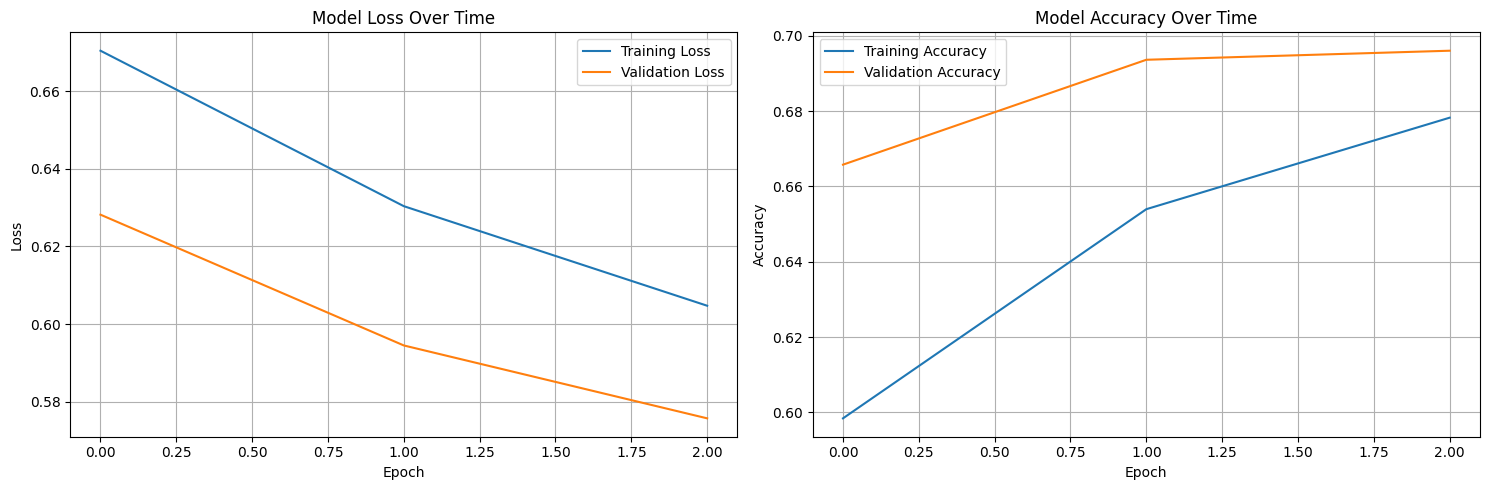


2. Analyzing predictions...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
current threshold:  0.53335774


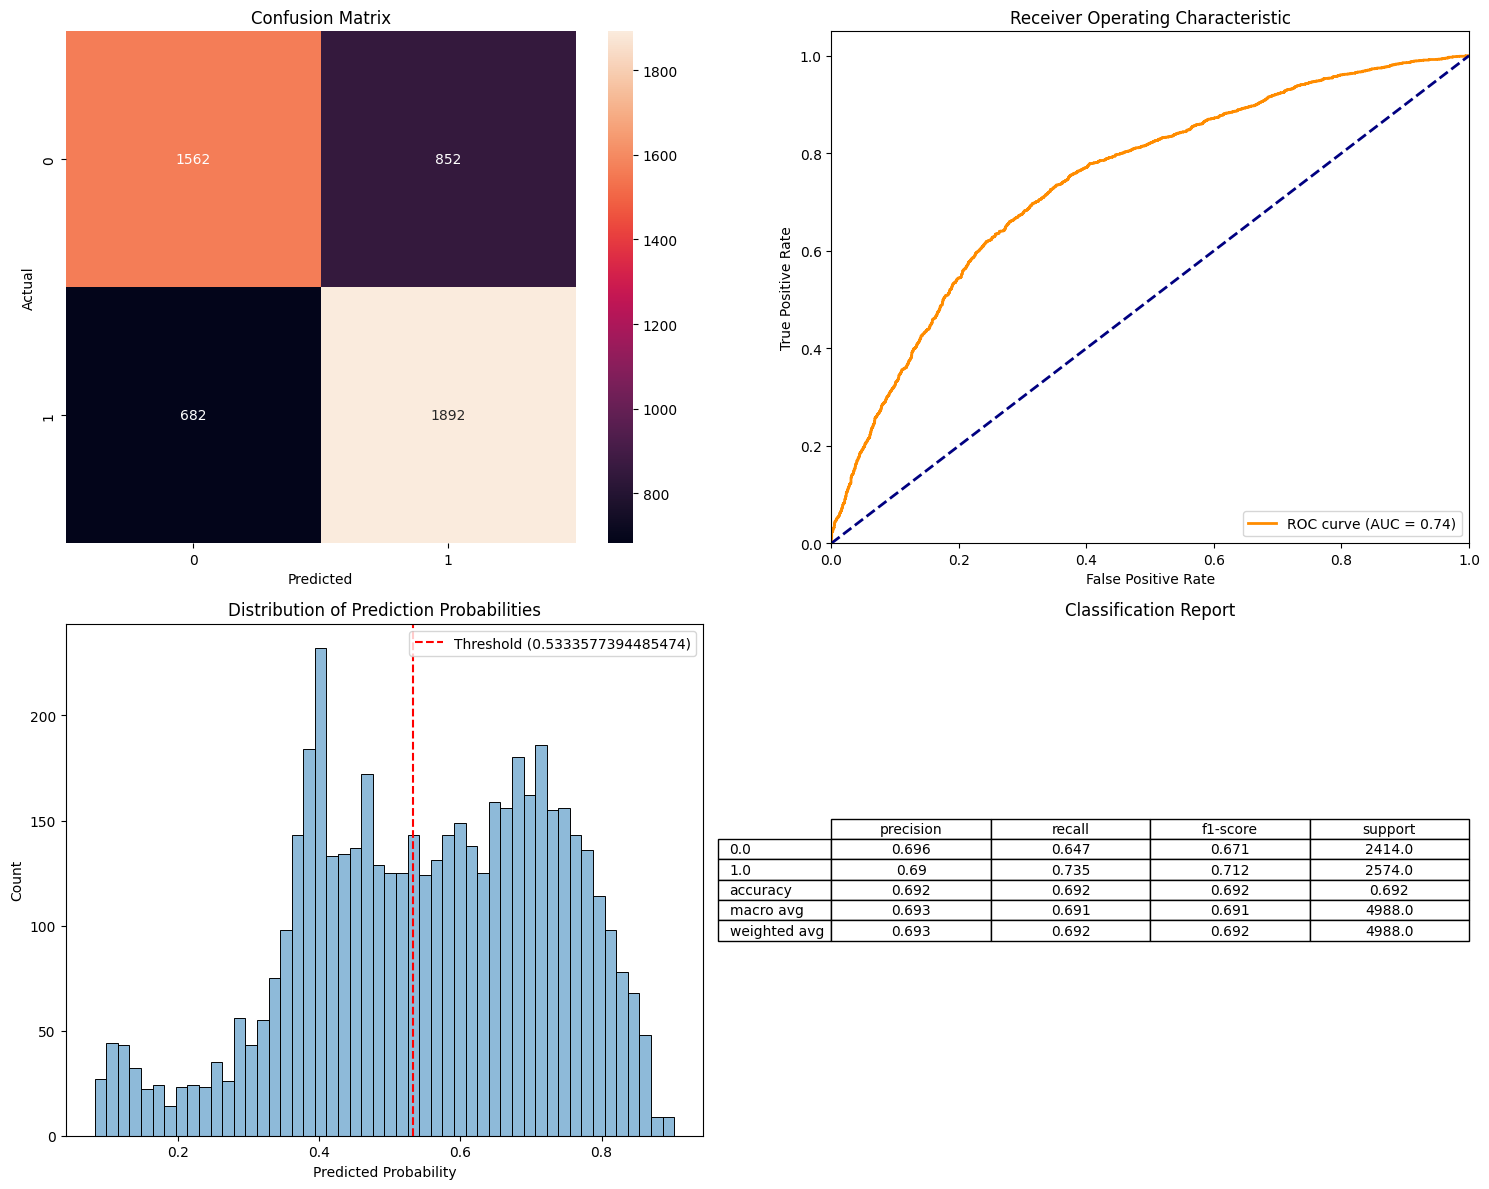


3. Analyzing prediction errors...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 


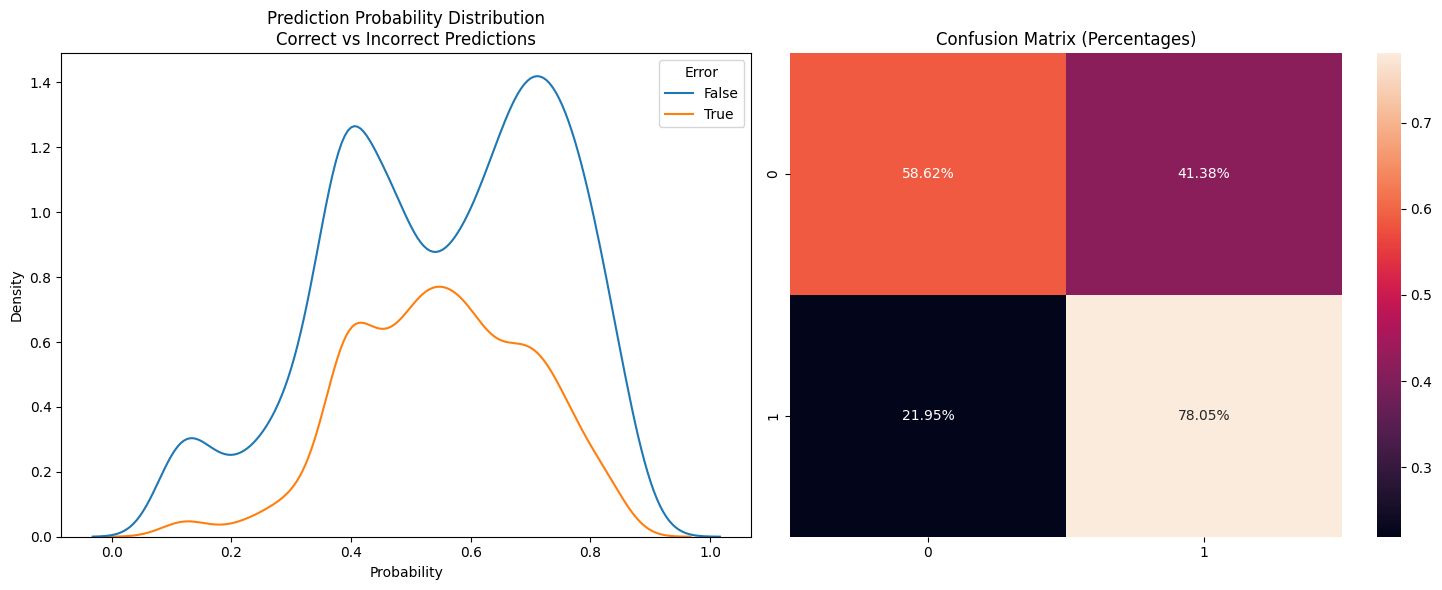


4. Evaluating prediction horizons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 


In [ ]:
# Clear the session to reset the model
backend.clear_session()

# Train model
start_mlflow_run(mlflow_run_name, n_trials)

## References

[1] O’Shea, K., & Nash, R. (2015, November 26). An introduction to convolutional neural networks. arXiv.org. https://arxiv.org/abs/1511.08458

[2] Ho, S., chreiter, Fakultat f ur Informatik, Schmidhub, J., er, & IDSIA. (1997). LONG SHORT-TERM MEMORY. Neural Computation, 9(8), 1735–1780. https://www.bioinf.jku.at/publications/older/2604.pdf 

[3] Optuna: A hyperparameter optimization framework — Optuna 4.1.0 documentation. (n.d.). https://optuna.readthedocs.io/en/stable/

[4] MLFlow: a tool for managing the machine learning lifecycle. (n.d.). https://mlflow.org/docs/latest/index.html